In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import util
from sklearn.datasets import fetch_mldata

%matplotlib inline 

### Download MNIST e separar apenas os exemplos de dígitos 0 e 1

In [2]:
mnist = fetch_mldata('MNIST original') 
vals = set()
for idx, label in enumerate(mnist.target):
    if (label == 0 or label == 6 or label == 9):
        vals.add(idx)
data_mnist = np.array([mnist.data[idx] for idx in vals])
label_mnist = np.array([mnist.target[idx] for idx in vals])
print(data_mnist.shape, label_mnist.shape)

(20737, 784) (20737,)


### Selecionando e visualizando um subdataset com n exemplos

In [3]:
new_data, new_labels = util.get_samples(data_mnist, 
                                        label_mnist, 
                                        size=3000)

In [4]:
#util.plot_img_grid(new_data, 
#                   new_labels, 
#                   max_cols = 5)

### Snippet simples que itera sobre uma lista de vetores de imagem e mostra eles em tela com uma pausa de 1 segundo 

In [5]:
#for i in range(len(new_labels)):
#    util.array_imshow(new_data[i], new_labels[i])
#    plt.pause(1)
#    display.clear_output(wait=True)
#    display.display(plt.gcf())

# Classificação dos dígitos 0, 6 e 9

Fiz três classificadores que usam a mesma ideia. Suponha que $w$ e $h$ são as dimensões da imagem, e chame de $r(x,y)$ toda a região retangular de tamanho $d_l\times d_c$ e posição $(x, y)$. Vou chamar de $\mu_{x,y}$ a média dos pixels de cada região $r(x,y)$.

As diferenças de cada classificador são as restrições.

**No segundo (`class_t = 1`):** (mais simples)

Tomo uma amostra de $m$ imagens e apenas seleciono as regiões que não se sobreponham. Então, para toda posição $(d_r.i, d_c.j)$, onde $i=\{0,\ldots,\frac{w}{d_r}\}$ e $j=\{0,\ldots,\frac{w}{d_c}\}$, pego estas regiões e computo as médias, separando as médias por seus rótulos $l$. Para classificar uma imagem, comparo cada média de região das amostras com a da imagem a ser classificada. Então, para cada $\hat{\mu}_i^l(x,y)$ e $\mu(x,y)$, as médias da i-ésima amostra com o rótulo $l$ na região $r(x,y)$ e da imagem a ser classificada, acho o erro:

$$e_i^l(x,y)=|\hat{\mu}_i^l(x,y)-\mu(x,y)|$$

E somo todos os erros:

$$\sum_{i=0}^m e_i^l(x,y)$$

Quero escolher o rótulo de menor erro, então acho:

$${\arg\max}_{l\in L}\sum_{i=0}^m e_i^l(x,y)\text{, onde $L$ é o conjunto de rótulos.}$$

O $l$ resultante é a classificação de menor erro.

**No primeiro (`class_t = 0`):**

Em uma amostra de $m$ imagens, fixo um tamanho $(d_r,d_c)$ e percorro todas as possíveis regiões de tamanho $(d_r,d_c)$ da imagem (mesmo as que se sobrepõe). Assim como no segundo, acho o erro subtraindo as médias da amostra com a da imagem a ser classificada.

**No terceiro (`class_t = 2`):**

Para o terceiro, ao invés de fixar os tamanhos das regiões da imagem, computo todas as médias de regiões retangulares de tamanho maior ou igual a $(d_r,d_c)$. Então agora vamos ter de considerar todas as regiões $r(x,y,p_w,p_h)$, onde $p_w$ e $p_h$ são a largura e a altura da região respectivamente. Além disso, crio um vetor $W$ de peso. Como certas regiões tem maior importância que outras, $W$ define uma ponderação para cada região retangular da imagem. Seja $E_i^l$ o vetor de erros $e_i^l(x,y,p_w,p_h)$ onde a região $r(x,y,p_w,p_h)$ é indexada através de alguma função injetora $f:\mathbb{Z}_w\times\mathbb{Z}_h\times\mathbb{Z}_w\times\mathbb{Z}_h\to\mathbb{Z}_k$. Achar o classificador é então minimizar a soma:

$${\arg\max}_{l\in L} \sum_i\sum_j E_i^l\cdot W$$

Substituindo $M_j^{(i,l)}=E_i^l\cdot W$, com $j$ indexando os elementos de $M$, queremos achar o rótulo com menor erro:

$${\arg\max}_{l\in L} \sum_{i=0}^m \sum_{j=0}^n M_j^i$$

Agora só falta provar que $f$ é injetora. A função injetora "mágica" $f$ é a função `encode`. Ela toma uma quádrupla $(x_1,y_1,x_2,y_2)$ e retorna um inteiro. Definimos $f$ como:

$$f(x_1,y_1,x_2,y_2) = ((y_1\cdot w+x_1)w+x_2)h+y_2$$

Onde $w$ e $h$ são constantes positivas maiores que zero (no nosso caso as dimensões da imagem). Vamos provar que $f$ é injetora:

*Dem.*

Queremos mostrar que se $f(a, b, c, d) = f(a', b', c', d')$, então $(a, b, c, d) = (a', b', c', d')$. Tomamos $a, c, a', c'\in\mathbb{Z_w}$ e $b, d, b', d'\in\mathbb{Z_h}$, e suponhamos que $f(a, b, c, d)=f(a', b', c', d')$. Então:

$$((bw+a)w+c)h+d = ((b'w+a')w+c')h+d'$$

Desenvolvendo, temos:

$$w^2 h(b-b')+wh(a-a')+h(c-c')+(d-d')=0$$

Mas $w,h > 0$. Então, é necessário que $a-a'=0$, $b-b'=0$, $c-c'=0$, $d-d'=0$ para que $f(a,b,c,d)=f(a',b',c',d')$. Disso temos que $a=a'$, $b=b'$, $c=c'$, $d=d'$. Portanto, segue que $f$ é injetora.
$$\tag*{$\blacksquare$}$$

O terceiro classificador, apesar de ser mais geral, demora muito mais, já que pega todos as possíveis regiões retangulares da imagem.

# Resultados

Os dois primeiros classificadores tiveram resultados mais ou menos iguais. Para tamanho 1000 e amostra 100, os três ficaram com .85, .90 de acurácia. O problema foi quando aumenta-se o tamanho da amostra. Como o erro vai acumulando, ter uma amostra grande, contra-intuitivamente, é pior. Uma melhoria seria pegar a média das médias, já que o erro se estabilizaria no final. Os três tiveram dificuldade em diferenciar o dígito 0, mas fizeram poucos erros quando classificaram 6 e 9. Os resultados foram mais ou menos iguais para os três classificadores, mas o terceiro demorou muito mais. Os resultados ficaram muito piores quando aumentou-se a amostra e o dataset de treino. Uma melhoria seria ajustar o $W$ para dar mais importância a certas regiões. Infelizmente, como o terceiro classificador demora demais, não deu tempo para se ajustar tão bem os valores de $W$.

In [6]:
sample_data, sample_label = util.get_samples(data_mnist, label_mnist, size=300)
img_w, img_h = 28, 28
class_t = 0
R = {}

def encode(x1, y1, x2, y2):
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    return int(((y1*img_w+x1)*img_w+x2)*img_h+y2)
def decode(k):
    y2 = k%img_h
    c = (k-y2)/img_h
    x2 = c%img_w
    c = (c-x2)/img_w
    x1 = c%img_w
    y1 = (c-x1)/img_w
    return x1, y1, x2, y2

def get_index(x1, y1, x2, y2):
    return R[encode(x1, y1, x2, y2)]
                
def get_params(dx, dy, n, min_w=2, min_h=2):
    S = {}
    if class_t == 0:
        for i in range(len(sample_data)):
            s = []
            d = util.array2img(sample_data[i])
            for x in range(0, img_w-dx):
                for y in range(0, img_h-dy):
                    s.append(np.mean(d[x:x+dx, y:y+dy]))
            l = sample_label[i]
            if not (l in S):
                S[l] = []
            S[l].append(s)
        return S, dx, dy
    elif class_t == 1:
        dx, dy = int(img_w/n), int(img_h/n)
        for i in range(len(sample_data)):
            s = []
            d = util.array2img(sample_data[i])
            for x in range(0, n-1):
                for y in range(0, n-1):
                    s.append(np.mean(d[x*dx:(x+1)*dx, y*dy:(y+1)*dy]))
                    
            l = sample_label[i]
            if not (l in S):
                S[l] = []
            S[l].append(s)
        return S, dx, dy, n
    else:
        m = 0
        for x in range(0, img_w):
            for y in range(0, img_h):
                for a in range(x+min_w, img_w):
                    for b in range(y+min_h, img_h):
                        x1, y1, x2, y2 = x, y, a, b
                        #print(x1, y1, x2, y2, "=", m)
                        R[encode(x1, y1, x2, y2)] = m
                        m += 1
        for i in range(len(sample_data)):
            s = []
            d = util.array2img(sample_data[i])
            for x in range(0, img_w):
                for y in range(0, img_h):
                    for a in range(x+min_w, img_w):
                        for b in range(y+min_h, img_h):
                            x1, y1, x2, y2 = x, y, a, b
                            s.append(np.mean(d[x1:x2, y1:y2]))
            l = sample_label[i]
            if not (l in S):
                S[l] = []
            S[l].append(s)
        return S, m
    
W = None
min_w, min_h = 2, 2
def initialize_classifier(dx=2, dy=2, n=14, w=2, h=2):
    min_w, min_h = w, h
    W = None
    if class_t == 0:
        S, dx, dy = get_params(dx, dy, n)
        return S, dx, dy
    elif class_t == 1:
        S, dx, dy, nS = get_params(dx, dy, n)
        return S, dx, dy, nS
    else:
        S, m = get_params(dx, dy, n, min_w, min_h)
        W = np.full(m, 0.01)
        # Da mais importancia as regioes seguintes:
        W[get_index(0, 0, img_w/2, img_h-1)] = 0.25
        W[get_index(img_w/2, 0, img_w-1, img_h-1)] = 0.25
        W[get_index(0, 0, img_w-1, img_h/2)] = 0.25
        W[get_index(0, img_h/2, img_w-1, img_h-1)] = 0.25
        W[get_index(10, 10, 18, 18)] = 0.25
        return S

def classifier(flat_img):
    img = util.array2img(flat_img)
    P = []
    if class_t == 0:
        for x in range(0, img_w-dx):
            for y in range(0, img_h-dy):
                P.append(np.mean(img[x:x+dx, y:y+dy]))
    elif class_t == 1:
        for x in range(0, nS-1):
            for y in range(0, nS-1):
                P.append(np.mean(img[x*dx:(x+1)*dx, y*dy:(y+1)*dy]))
    else:
        for x in range(0, img_w):
            for y in range(0, img_h):
                for a in range(x+min_w, img_w):
                    for b in range(y+min_h, img_h):
                        P.append(np.mean(img[x:a, y:b]))
    ml, l = -1, -1
    for k, samples in S.items():
        d = 0
        for i in range(len(samples)):
            X = np.asarray(samples[i])-np.asarray(P)
            if class_t == 2:
                X = X.dot(W)
            d += np.sum(np.absolute(X))
        d /= len(samples)
        if (ml == -1 or d < l):
            l, ml = d, k
    return ml

In [7]:
def predictor(data, classifier=None):
    assert classifier is not None, "Classifier not implemented or not passed to predictor function"
    predictions = []
    for i,_ in enumerate(data):
        class_prediction = classifier(data[i])
        predictions.append(class_prediction)

    predictions = np.asarray(predictions, 
                             dtype=new_labels.dtype)
    return predictions

def evaluator(true_labels, predicted_labels, normalized=True):
    assert true_labels.shape[0] == predicted_labels.shape[0], "Original labels and predicted labels \
                                                               doesn't match in rows number"
    util.plot_confusion_matrix_metrics(true_labels=true_labels,
                                       predicted_labels=predicted_labels,
                                       normalized=True)

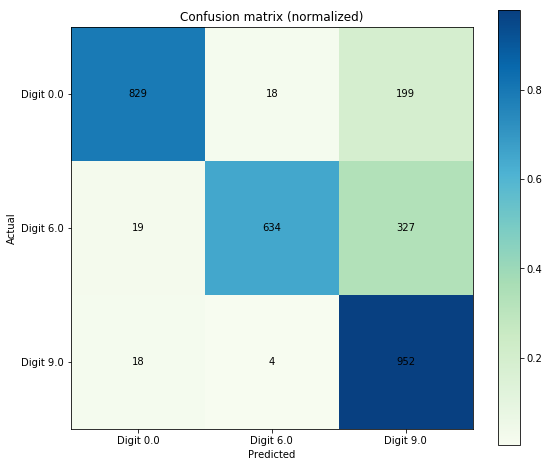

Predicted  0.0  6.0   9.0  __all__
Actual                            
0.0        829   18   199     1046
6.0         19  634   327      980
9.0         18    4   952      974
__all__    866  656  1478     3000
Evaluation metrics:
Confusion Matrix:

Predicted  0.0  6.0   9.0  __all__
Actual                            
0.0        829   18   199     1046
6.0         19  634   327      980
9.0         18    4   952      974
__all__    866  656  1478     3000


Overall Statistics:

Accuracy: 0.805
95% CI: (0.7903611251113765, 0.8190415313749708)
No Information Rate: ToDo
P-Value [Acc > NIR]: 2.118191183389046e-274
Kappa: 0.7080698476573729
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                      0.0        6.0        9.0
Population                                  3000       3000       3000
P: Condition positive                       1046        980        974
N: Condition negative                       1954       2020       2026
Test outcome positive  

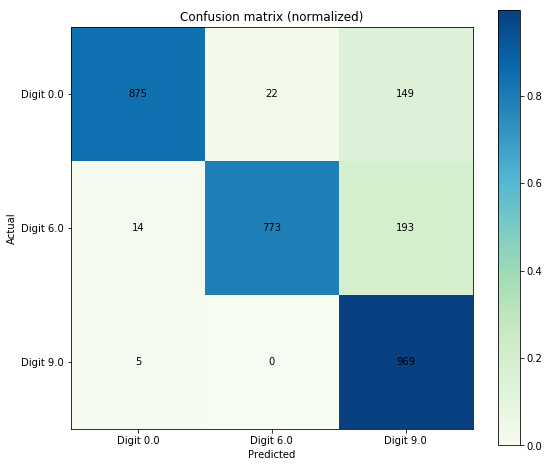

Predicted  0.0  6.0   9.0  __all__
Actual                            
0.0        875   22   149     1046
6.0         14  773   193      980
9.0          5    0   969      974
__all__    894  795  1311     3000
Evaluation metrics:
Confusion Matrix:

Predicted  0.0  6.0   9.0  __all__
Actual                            
0.0        875   22   149     1046
6.0         14  773   193      980
9.0          5    0   969      974
__all__    894  795  1311     3000


Overall Statistics:

Accuracy: 0.8723333333333333
95% CI: (0.8598610548248783, 0.8840743302941712)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.0
Kappa: 0.8087824283533219
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                       0.0        6.0         9.0
Population                                   3000       3000        3000
P: Condition positive                        1046        980         974
N: Condition negative                        1954       2020        2026
Test outcome positive

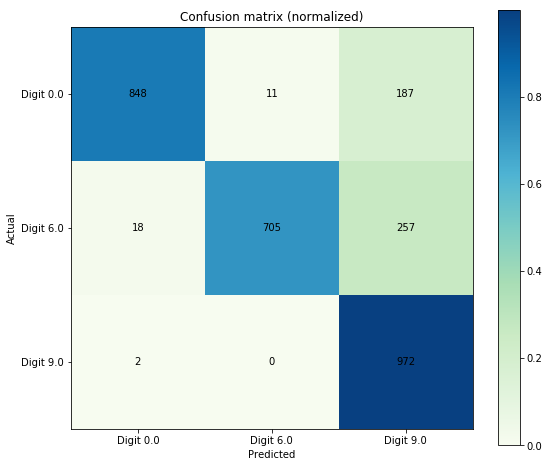

Predicted  0.0  6.0   9.0  __all__
Actual                            
0.0        848   11   187     1046
6.0         18  705   257      980
9.0          2    0   972      974
__all__    868  716  1416     3000
Evaluation metrics:
Confusion Matrix:

Predicted  0.0  6.0   9.0  __all__
Actual                            
0.0        848   11   187     1046
6.0         18  705   257      980
9.0          2    0   972      974
__all__    868  716  1416     3000


Overall Statistics:

Accuracy: 0.8416666666666667
95% CI: (0.8281049231878462, 0.8545583904386362)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.0
Kappa: 0.7629428228069964
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                      0.0         6.0         9.0
Population                                  3000        3000        3000
P: Condition positive                       1046         980         974
N: Condition negative                       1954        2020        2026
Test outcome positive

In [8]:
class_t = 3
S = initialize_classifier(w=2, h=2)
predictions = predictor(new_data, classifier=classifier)
evaluator(true_labels=new_labels, predicted_labels=predictions)
class_t = 0
S, dx, dy = initialize_classifier(5, 5, 14)
predictions = predictor(new_data, classifier=classifier)
evaluator(true_labels=new_labels, predicted_labels=predictions)
class_t = 1
S, dx, dy, nS = initialize_classifier(2, 2, 7)
predictions = predictor(new_data, classifier=classifier)
evaluator(true_labels=new_labels, predicted_labels=predictions)